# Multilayer Perceptron (MLP)
The textbook introduces multilayer perceptrons with the application 
of learning to compute the XOR (exclusive OR) logical function.  XOR
is a function of two inputs, and returns true whenever one of the inputs
is 1 and the other is zero.  We could think of it as returning true
only when the inputs do not contain the same truth value.

| $x_1$ | $x_2$ | r  |
|:------|:------|:---|
| 0     | 0     | 0  |
| 0     | 1     | 1  |
| 1     | 0     | 1  |
| 1     | 1     | 0  |

We will use Python code with some help from the Numpy library to implement a simple two-layer Multi-Layer Perceptron (MLP) model to learn the XOR function.

We are using $\operatorname{sigmoid}$ activations for both the hidden layer and the output layer.

First, include some modules

In [77]:
import numpy as np
import matplotlib.pyplot as plt

We represent our input values as `X`, and the ground truth as `r`:

In [78]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

r = np.array([0, 1, 1, 0])

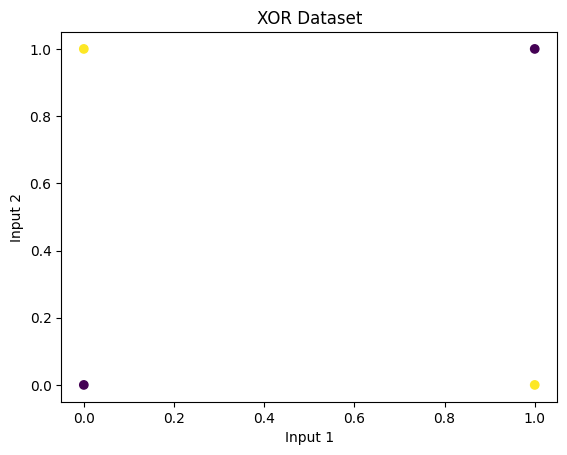

In [79]:
# plotting the XOR dataset where each point is 
# colored according to its label
plt.scatter(X[:,0], X[:,1], c=r, cmap='viridis')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('XOR Dataset')
plt.show()

For the MLP, we need two sets of weights.  One is for the hidden layer and one is for the output layer.

For clarity in this exercise, we will declare them as separate variables---in practice they could also be represented as a Python list where each layer was a Numpy array within the list.  We will refer to the hidden layer weights as $w_0$ and the output layer weights as $w_1$.

This time, we will let the initial weights be drawn from the Normal distribution $\mathcal{N}(\mu=0, \sigma=0.05)$.

The Python code for this looks like:

    np.random.seed(2024)
    w0 = np.random.normal(0, 0.5, size=(2,3))
    w1 = np.random.normal(0, 0.5, size=(1,3))

and with that specific seed, it gives us:

    w0 = [[ 0.83402366  0.36867386 -0.10076888]
          [-0.07545597  0.4580259   0.58016482]]
    w1 = [[-1.309981   -0.66264729  0.22999431]]

Now, we use gradient descent to train.  Recall that one epoch is one full pass through all samples. The algorithm is:

    For each epoch:
        for each sample:
            predict this sample
            determine the error
            determine the weight update required ("delta")
            apply the update

We are using $\operatorname{sigmoid}$, represented by $S(a)$, for activation at both hidden units and the output unit.

To backpropagate the error, we need the derivative of sigmoid:

$$
\operatorname{S}(a)' = \operatorname{S}(a)(1 - \operatorname{S}(a))
$$

But since our output `y` (at the output layer) was the function of the hidden layer *passed through the $S(a)$ activation*, we can reduce this to:

$$
\operatorname{S}(f(z))' = y(1-y)
$$

And in fact, at the hidden units $z_1$ and $z_2$ we also applied sigmoid, so the update to the weights at $w_0$ involves the function of $x_i$ *already passed through sigmoid*:

$$
\operatorname{S}(f(x))' = z_h(1-z_h)
$$

(For a good explanation of how we arrive at the compact form of the derivative see: [https://beckernick.github.io/sigmoid-derivative-neural-network/](https://beckernick.github.io/sigmoid-derivative-neural-network/) )

### Calculating weight updates: backpropagating through multiple layers

We will calculate our weight updates in parts this time, so that we can make use of intermediate values we calculate along the way.  After we calculate all of the weight and bias "deltas", we will apply them at once, scaling by the learning factor.

#### Output Layer
The output layer is just a perceptron whose inputs are the values computed by the hidden units $\boldsymbol{z}$.

To compute the "deltas" for the weights, we need the derivative of the error, which is $(r-y)$ for incremental learning, and the derivative of the activation function $y(1-y)$, and the input $\boldsymbol{x}$ (leave off the $\boldsymbol{x}$ when updating the bias).

Our output weights are the second set of weights in the model (from the perspective of the forward pass), so we index them with a 1, giving us $\boldsymbol{w_1}$.  For simplicity, we will refer to the biases here as $b_1$.  But keep in mind that the biases are stored in the first column of the same matrix as the weights, so the weighs are in `weights[1][:,1:]` and the corresponding biases are in `weights[1][:,0]` in the Python code below.  The first index operator gets the *layer*, the second chooses all rows at columns selected by the part following the comma.

Our weight updates are given by:
$$
\begin{aligned}
Err^{(output)} &= (r - y) \\
\Delta \boldsymbol{w_1} &= Err^{(output)} \cdot \operatorname{S}'(y) \cdot \boldsymbol{z} \\
\Delta \boldsymbol{b_1} &= Err^{(output)} \cdot \operatorname{S}'(y) \\
~\\
\text{and} \\
~\\
\boldsymbol{w_1}^{(update)} &= \eta \cdot \Delta \boldsymbol{w_1} \\
\boldsymbol{b_1}^{(update)} &= \eta \cdot \Delta \boldsymbol{b_1}
\end{aligned}
$$
where $\eta$ is the learning rate.

Notice that the bias is almost the same, except that we don't multiply by the *input*, which is the $\boldsymbol{z}$ term here.

#### Hidden Layer

For the hidden layer weights, we need the error with respect to each hidden unit, taking into account the sigmoid at the output layer, and the weights between the hidden layer and the output layer ($w_1$).  Here is what we need:
$$
Err^{(z)} = Err^{(output)} \cdot \operatorname{S}'(y) \cdot \boldsymbol{z} \cdot w_1
$$

But notice that we have most of this calculation done already:
$$
\begin{aligned}
\Delta \boldsymbol{w_1} &= Err^{(output)} \cdot \operatorname{S}'(y) \cdot \boldsymbol{z} \\
~\\
\text{so} \\
~\\
Err^{(z)} &= \Delta \boldsymbol{w_1} \cdot w_1
\end{aligned}
$$

Now, the updates for the hidden layer weights look like:
$$
\begin{aligned}
\Delta \boldsymbol{w_0} &= Err^{(z)} \circ \operatorname{S}'(z)^{T} \cdot \boldsymbol{x}\\
\Delta \boldsymbol{b_0} &= Err^{(z)} \circ \operatorname{S}'(z)\\
~\\
\text{and} \\
~\\
\boldsymbol{w_0}^{(update)} &= \eta \cdot \Delta \boldsymbol{w_0} \\
\boldsymbol{b_0}^{(update)} &= \eta \cdot \Delta \boldsymbol{b_0}
\end{aligned}
$$
where the $\circ$ operator indicates a Hadamard product, which is element-wise multiplication (this can be done in Python with [`np.multiply()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.multiply.html)).

\newpage

## Implement the algorithm to learn XOR

In [99]:
# Sigmoid activation function
def sigmoid(a):
    """sigmoid activation function"""
    return 1 / (1 + np.exp(-a))


# And its derivative (which assumes `a` already passed
# through sigmoid once).
def sigmoid_deriv(a):
    """derivative of the sigmoid
    (assuming a has already passed through sigmoid once)
    """
    return a * (1 - a)


# This function will take a matrix that needs a column of 1's pre-pended to
# the front, and it will return a copy of that matrix where the first column
# is all 1's (and the rest is the original argument matrix m)
# It can be used so that we don't have to calculate and _store_ the augmented
# version of X or z.
def augment_for_bias(m):
    if len(m.shape) > 1:
        mhat = np.ones((m.shape[0], m.shape[1] + 1))
        mhat[:, 1:] = m
    else:
        mhat = np.concatenate(([1], m))
    return mhat


# To make it clear what is happening in training, this version will define
# the forward pass (which does prediction) and the backward pass (which
# backpropagates the error) as functions.  Then each training update just
# consists of running a forward pass followed by a backward pass.
def forward_pass(X, weights):
    # The first layer performs `sigmoid(w0 .* aX)` where aX is X augmented for bias (by
    # the function defined above).
    # This produces the latent (hidden) unit values `z`:
    z = sigmoid(weights[0] @ augment_for_bias(X))

    # Second layer takes the `z` values as inputs, and calculates the output
    # `y`.  The formula is `y = sigmoid(az * w1^T)` where az is the augmented `z`
    # (as we did with X above) and "^T" means transposed.  (check matrix dimensions
    # on paper to verify why)
    y = sigmoid(weights[1] @ augment_for_bias(z))

    # Now, we will save the activations in layer-index order for use later in the
    # backward pass.
    activations = [z, y]
    return y, activations


# The backward pass performs backpropagation to update the weights.
# It needs to know the inputs X, the ground truth r, and
# the intermediate values calculated for hidden layers and the
# predicted outputs.
# The outputs and the hidden layer values are all contained in the
# "activations" list returned from the `forward_pass()` function.
def backward_pass(X, r, weights, activations, learning_rate):
    z, y = activations  # This just "unpacks" the activations into meaningful variable names

    # The Error_output is just r - y  We will just name it `err` because it is the overall
    # prediction error.
    err = r - y

    # Now calculate the "delta" (not including learning rate yet) for the weights w1
    # using the formula given above.  Note the `sigmoid_deriv()` function above.
    delta_w1 = err * sigmoid_deriv(y) @ augment_for_bias(z).T

    # Calculate the "delta" for bias b1 using the formula above.
    delta_b1 = err * sigmoid_deriv(y)

    # Calculate the amount of error with respect to each hidden unit in `z`:
    # We will call this one `err_z`.  See the formula above.  Keep in mind that
    # the **weights** w1 are in  `weights[1][:,1:]`  (that excludes the first column
    # which contains the bias) 
    err_z = (weights[1][:, 1:].T @ err) * sigmoid_deriv(z)

    # Calculate the "delta" for w0.  See formula above.
    delta_w0 = err_z @ augment_for_bias(X).T

    # And now, calculate the bias delta for b0.
    delta_b0 = err_z

    # Apply the weight updates, being careful to weight each of them
    # by the learning rate (multiply by learning rate for each).
    weights[0] += learning_rate * delta_w0
    weights[1] += learning_rate * delta_w1

    return err  # return for reporting purposes during training.


np.random.seed(2024)
# Random weights will be chosen from the normal distribution, with
# a center at zero and a stddev of 0.5
w0 = np.random.normal(0, 0.5, size=(2, 3))
w1 = np.random.normal(0, 0.5, size=(1, 3))
print("Initial random weights: \n{}\n{}\n".format(w0, w1))

# Let's bundle the weights into a Python list.  The first layer weights
# w0 will be the first element in the array weights[0] and the second layer
# weights w1 will be weights[1].
weights = [w0, w1]

# This one takes some time to train; we will use 25000 epochs (max).
n_epochs = 25000
# The learning rate (eta) is relatively small (0.1):
learning_rate = 0.1

# This part prints the initial predictions using the random weights with
# no training.
print("Before training-------")
for i in range(len(X)):
    y, _ = forward_pass(X[i], weights)
print("{} XOR {} = {}  (r = {})".format(X[i][0], X[i][1], y, r[i]))
print("----------------------")

# TRAINING process.  We are using "online" (pure incremental learning)
# so we will forward-pass and backward-pass for each example.
avg_err_each_epoch = []
for epoch in range(n_epochs):  # for each epoch
    log = ""
    epoch_err = []
    for i in range(len(X)):  # for each sample
        # Run a forward pass:
        y, activations = forward_pass(X[i], weights)
        # Then run a backward pass to update the weights:
        err = backward_pass(X[i], r[i], weights, activations, learning_rate)
        # Collect the error for later analysis.
        epoch_err.append(err)
        # And write some info to the log that will output every 10th epoch...
        log += "err {}: {}\n".format(i, err)

    # Some progress output is written every 10 epochs, and on the last epoch
    if epoch % 100 == 0 or epoch == n_epochs - 1:
        print("After epoch {}:".format(epoch))
        print(log)
        print("Weights:\nw0:\n{}w1:\n{}\n".format(w0.round(4), w1.round(4)))
        for i in range(len(X)):
            y, _ = forward_pass(X[i], weights)
            print("{} XOR {} = {}  (r = {})".format(X[i][0], X[i][1], y, r[i]))
        print("")
    avg_err_each_epoch.append(np.mean(np.abs(epoch_err)))
    # We will employ early stopping -- if the mean absolute error becomes less
    # than 0.1, we will stop.
    if avg_err_each_epoch[-1] < 0.1:
        print("Early stopping condition triggered at epoch {}.".format(epoch))
        break


Initial random weights: 
[[ 0.83402366  0.36867386 -0.10076888]
 [-0.07545597  0.4580259   0.58016482]]
[[-1.309981   -0.66264729  0.22999431]]

Before training-------
1 XOR 1 = [0.16233741]  (r = 0)
----------------------


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

### Verify your results

If all goes well, your final output should look like:
    
    After epoch 9200:
    err 0: [-0.09966309]
    err 1: [0.09794036]
    err 2: [0.09771296]
    err 3: [-0.10875869]

    Weights:
    w0:
    [[-3.9021  3.1011  3.0935]
    [-1.2637  5.4614  5.3688]]w1:
    [[-3.9501 -7.4463  8.6063]]

    0 XOR 0 = [0.09964545]  (r = 0)
    0 XOR 1 = [0.90217921]  (r = 1)
    1 XOR 0 = [0.90218792]  (r = 1)
    1 XOR 1 = [0.10836331]  (r = 0)

    Early stopping condition triggered at epoch 9253.

If we want to get integer outputs instead of the floating point outputs, we would just round to the nearest integer.

### Plot the training curve:
This is how our error improved over time:

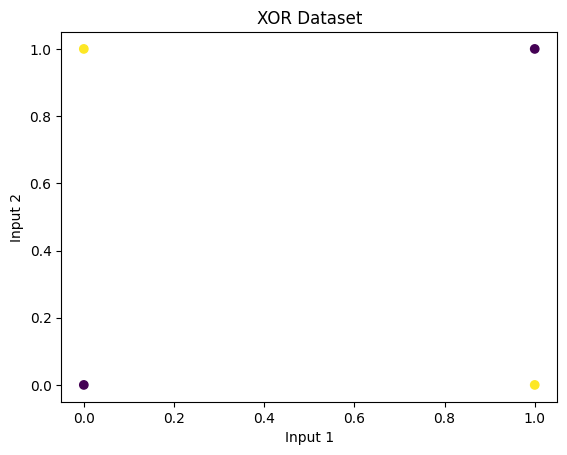

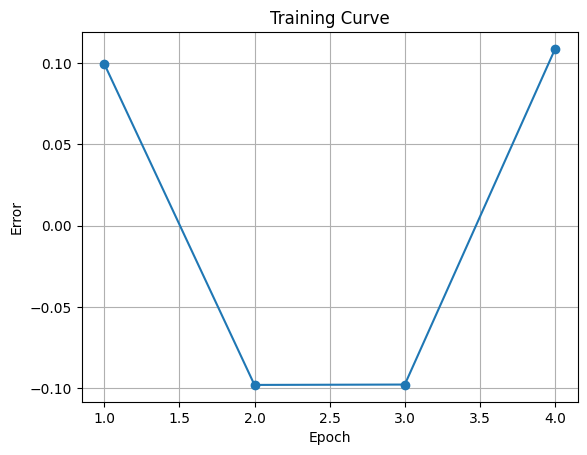

In [ ]:
import matplotlib.pyplot as plt

# Define the error values and epochs
error_values = [0.09966309, -0.09794036, -0.09771296, 0.10875869]
epochs = range(1, len(error_values) + 1)

# Plot the training curve
plt.plot(epochs, error_values, marker='o', linestyle='-')
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.grid(True)
plt.show()


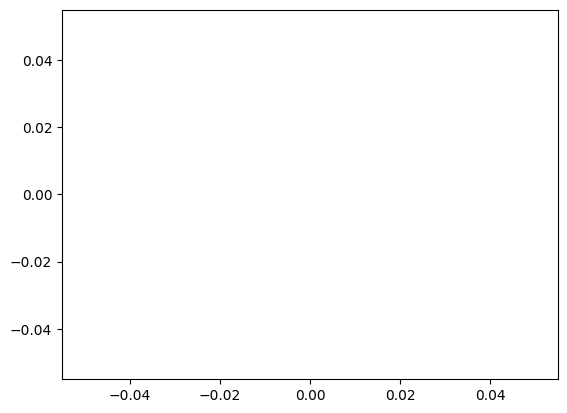

In [ ]:
plt.plot(avg_err_each_epoch)
plt.show()

This model took a relatively long time to begin making progress, but then trained quickly.  That training pattern is not unusual with neural networks.  We would prefer a shorter "idle" time at the beginning...  Progressive learning rates (larger, then smaller as training goes on) could help with that.

**********************************************************************************************************************************